In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


# Import and Preparation

In [2]:
df_train = pd.read_csv('../input/train.csv', index_col='PassengerId')
df_test = pd.read_csv('../input/test.csv', index_col='PassengerId')
df_gender_sub = pd.read_csv("../input/gender_submission.csv", index_col='PassengerId')

In [3]:
# Storing the target separately
Survived = df_train.loc[:,'Survived']
df_train = df_train.drop(['Survived'], axis=1).copy()

# Saving index for train test split 
train_index = df_train.index
test_index = df_test.index

# Concate the two datasets
df_all = pd.concat([df_train, df_test])

# dont needed anymore
##del df_train
##del df_test

# Create new feature Family true/false
df_all.loc[:,'Family'] = ((df_all['SibSp'] > 0) | (df_all['Parch'] > 0)).replace(True, 1, inplace=False)
df_all.loc[:,'Family'] = df_all.loc[:,'Family'].astype(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7121c5a20>,
      dtype=object)

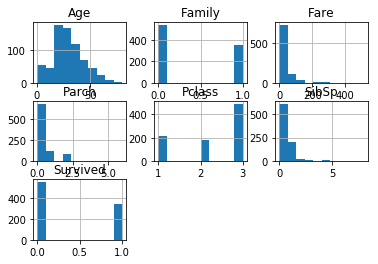

In [4]:
pd.concat([df_all.loc[train_index,:],Survived], axis=1).hist()



# Missing Values

In [5]:
# Function for nullanalysis
def nullAnalysis(df):
    tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})

    tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
    return tab_info

In [6]:
# Show the null values
nullAnalysis(df_all)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
column type,int64,object,object,float64,int64,int64,object,float64,object,object,int64
null values (nb),0,0,0,263,0,0,0,1,1014,2,0
null values (%),0,0,0,20.0917,0,0,0,0.0763942,77.4637,0.152788,0


## Age

In [7]:
# First 10 datarows where age is null
df_all[df_all.loc[:,'Age'].isnull()].head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,,,,,
6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
18,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,0
20,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0
27,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,0
29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,0
30,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S,0
32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,1
33,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,0
37,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,0


In [8]:
# Average age overall
print("Average age of a passengers: ", round(df_all.loc[:,'Age'].agg('mean'),0))

Average age of a passengers:  30.0


In [9]:
# Average age per class
df_all.groupby('Pclass')['Age'].agg('mean')

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

We will use the average age of the corresponding class to fill the missing passenger ages. This would be the best fit for that problem.

In [10]:
# Setting the average age of each class for the missing values inside the corresponding class
df_all.loc[(df_all['Age'].isnull()) & (df_all['Pclass'] == 1), ['Age']] = round(df_all.groupby('Pclass')['Age'].agg('mean')[1],0)
df_all.loc[(df_all['Age'].isnull()) & (df_all['Pclass'] == 2), ['Age']] = round(df_all.groupby('Pclass')['Age'].agg('mean')[2],0)
df_all.loc[(df_all['Age'].isnull()) & (df_all['Pclass'] == 3), ['Age']] = round(df_all.groupby('Pclass')['Age'].agg('mean')[3],0)

## Cabin

In [11]:
# Show all Cabins with NaN data
df_all.loc[(df_all['Cabin'].isnull())] 

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
6,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,NaN,Q,0
8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1
10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1
13,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S,0
14,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,1


In [12]:
# Fill the nan data with coresponding cabin out of the Pclass
#df_all.loc[df_all.loc[:,'Pclass'] == 3,['Cabin']].fillna(method='bfill')

#df_all.loc[:,'Cabin'].fillna(method='ffill')

In [13]:
df_all.groupby('Pclass')['Age','Parch','Fare'].agg(['max','min','mean'])

Age                     ...          Fare                
         max   min       mean    ...           max  min       mean
Pclass                           ...                              
1       80.0  0.92  39.140619    ...      512.3292  0.0  87.508992
2       70.0  0.67  29.535199    ...       73.5000  0.0  21.179196
3       74.0  0.17  24.870240    ...       69.5500  0.0  13.302889

[3 rows x 9 columns]

In [14]:
# Group by Pclasses
df_all.groupby('Pclass').agg('count')

,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
Pclass,,,,,,,,,,
1,323,323,323,323,323,323,323,256,321,323
2,277,277,277,277,277,277,277,23,277,277
3,709,709,709,709,709,709,708,16,709,709


In [15]:
# Sex Distribution
df_all.groupby(['Sex']).agg('count')

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
Sex,,,,,,,,,,
female,466,466,466,466,466,466,466,141,464,466
male,843,843,843,843,843,843,842,154,843,843


# Visualizing Distribution

## Gender Distribution

In [16]:
df_all.groupby(['Parch']).agg('count')

,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Cabin,Embarked,Family
Parch,,,,,,,,,,
0,1002,1002,1002,1002,1002,1002,1001,205,1000,1002
1,170,170,170,170,170,170,170,56,170,170
2,113,113,113,113,113,113,113,29,113,113
3,8,8,8,8,8,8,8,3,8,8
4,6,6,6,6,6,6,6,2,6,6
5,6,6,6,6,6,6,6,0,6,6
6,2,2,2,2,2,2,2,0,2,2
9,2,2,2,2,2,2,2,0,2,2


The feature **Cabin** seems to have some missing values.

## Gender Distribution by Ticket Class
Following will show the gender distribution by ticket class.

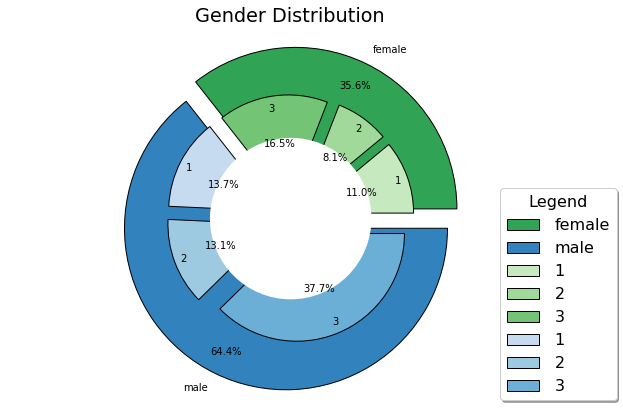

In [17]:
# Visualizing pie chart

fig, ax = plt.subplots(figsize=(10,7))

# Size and explsion
size_out = 3
size_in = 1
explode_out = (0.2,0.2)
explode_in = (0.3,0.3,0.3,0.3,0.3,0.3)

cmap = plt.get_cmap('tab20c')

outer_colors = cmap(np.array([8,0]))
inner_colors = cmap(np.array([11,10,9,3,2,1]))

circle1 = ax.pie(df_all.groupby(['Sex']).count().Name, radius=3, colors=outer_colors,
       labels=df_all.groupby(['Sex']).count().Name.index,autopct='%1.1f%%',pctdistance=0.85,
       wedgeprops=dict(width=size_out, edgecolor='black'),
       explode = explode_out)

circle2 = ax.pie(df_all.groupby(['Sex','Pclass']).count().Name, radius=2, colors=inner_colors,
       labels=[1,2,3,1,2,3],autopct='%1.1f%%', labeldistance=0.88,pctdistance=0.55,
       wedgeprops=dict(width=size_in, edgecolor='black'),
      explode = explode_in)

# Centre Cirle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.rcParams['font.size'] = 16.0
plt.rc_context

# Setting legend
ax.legend(loc='lower right', bbox_to_anchor=(0.6, 0., 0.5, 0.5), shadow=1,title='Legend',
          handletextpad=1, labelspacing=0.5)

ax.set(aspect="equal", title='Gender Distribution')
plt.axis('equal')
plt.show()

Here you can see the diffrent gender distributions to the ticket classes 1 to 3.

## NEXT

In [18]:
df_all.loc

In [19]:
# Concat Survived and training set 
fig = plt.figure(figsize=(12,10))
#gs = fig.add_gridspec(2, 2)
#ax1 = fig.add_subplot(gs[0, 0])
ax = fig.add_subplot()



df_all_survived = pd.concat([df_all.loc[train_index,:],Survived], axis=1)
df_all_survived 


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Survived
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0
6,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,NaN,Q,0,0
7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,0
8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,0
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1,1


<Figure size 864x720 with 0 Axes>

## Survived

### Male and Femal to Survived

### Ticket Class to Survived


### Age to Survived

https://matplotlib.org/gallery/statistics/boxplot_vs_violin.html#sphx-glr-gallery-statistics-boxplot-vs-violin-py

min age <br>
max age  <br>
mean age <br>

per class

boxplot je Pclass mit min age, max age, mean age



In [20]:
#df_all[['Age','Fare']]

#[y + 1 for y in range(len(df_all[['Age','Fare']]))]

In [95]:
[df_all['Age'].values, df_all['Fare'].values]


[array([22. , 38. , 26. , ..., 38.5, 25. , 25. ]),
 array([ 7.25  , 71.2833,  7.925 , ...,  7.25  ,  8.05  , 22.3583])]

In [22]:
np.random.seed(19680801)
all_data_1 = [np.random.normal(0, std, 100) for std in range(6, 10)]
all_data_1
#[y + 1 for y in range(len(all_data_1))]

[array([  6.29582586,   5.19659505,   3.3068076 ,  10.36846675,
         -3.8957287 ,  -2.87051746,   6.46731063,   5.812862  ,
         -4.85606876,  -7.42433462,  11.16069925,  -1.84991542,
          4.6978233 ,   0.12914068,   4.29398273,   8.40879904,
         -6.7650127 ,   9.93490932,   8.40576889,   1.21194042,
         -5.78918139,   6.26753107,  -2.58630412,  -2.98391698,
         -0.35470449,  -6.68762799,  -7.36198671,  -8.46052917,
          7.86516309,  -3.10465245,  -0.09994882,   2.81503351,
          4.66066857, -11.30818616,  -0.765524  ,  -3.11590462,
          4.41085932,   8.08110793,   3.30153032,  -1.37430695,
          3.96738976,  -3.2182108 ,  -2.89166626,   1.87634138,
        -18.73103117,  -8.15086207,  -0.85582924,  -1.30198155,
         -0.19720802,  10.9928681 ,   2.11415904,   1.4198708 ,
          8.87128839,   9.32583942,  -6.66365386,   4.94273138,
          3.99164813,   4.28859834,  -7.38472232,  12.57241276,
         -3.61931689,   9.68131836,  -1.

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.6/site-packages/numpy/linalg/linalg.py:2022: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


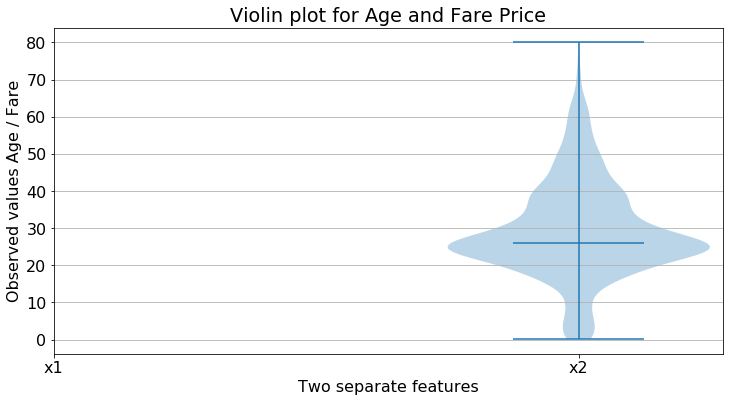

In [102]:
df_two_features = [df_all['Fare'].values, df_all['Age'].values]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# plot violin plot
axes.violinplot(df_two_features
                   ,showmeans=False,
                    showmedians=True)
axes.set_title('Violin plot for Age and Fare Price')

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y + 1 for y in range(len(df_two_features))])
axes.set_xlabel('Two separate features')
axes.set_ylabel('Observed values Age / Fare')

# add x-tick labels
plt.setp(axes, xticks=[y + 1 for y in range(len(df_two_features))],
         xticklabels=['x1', 'x2','x3'])
plt.show()


TypeError: 'Axes' object does not support indexing

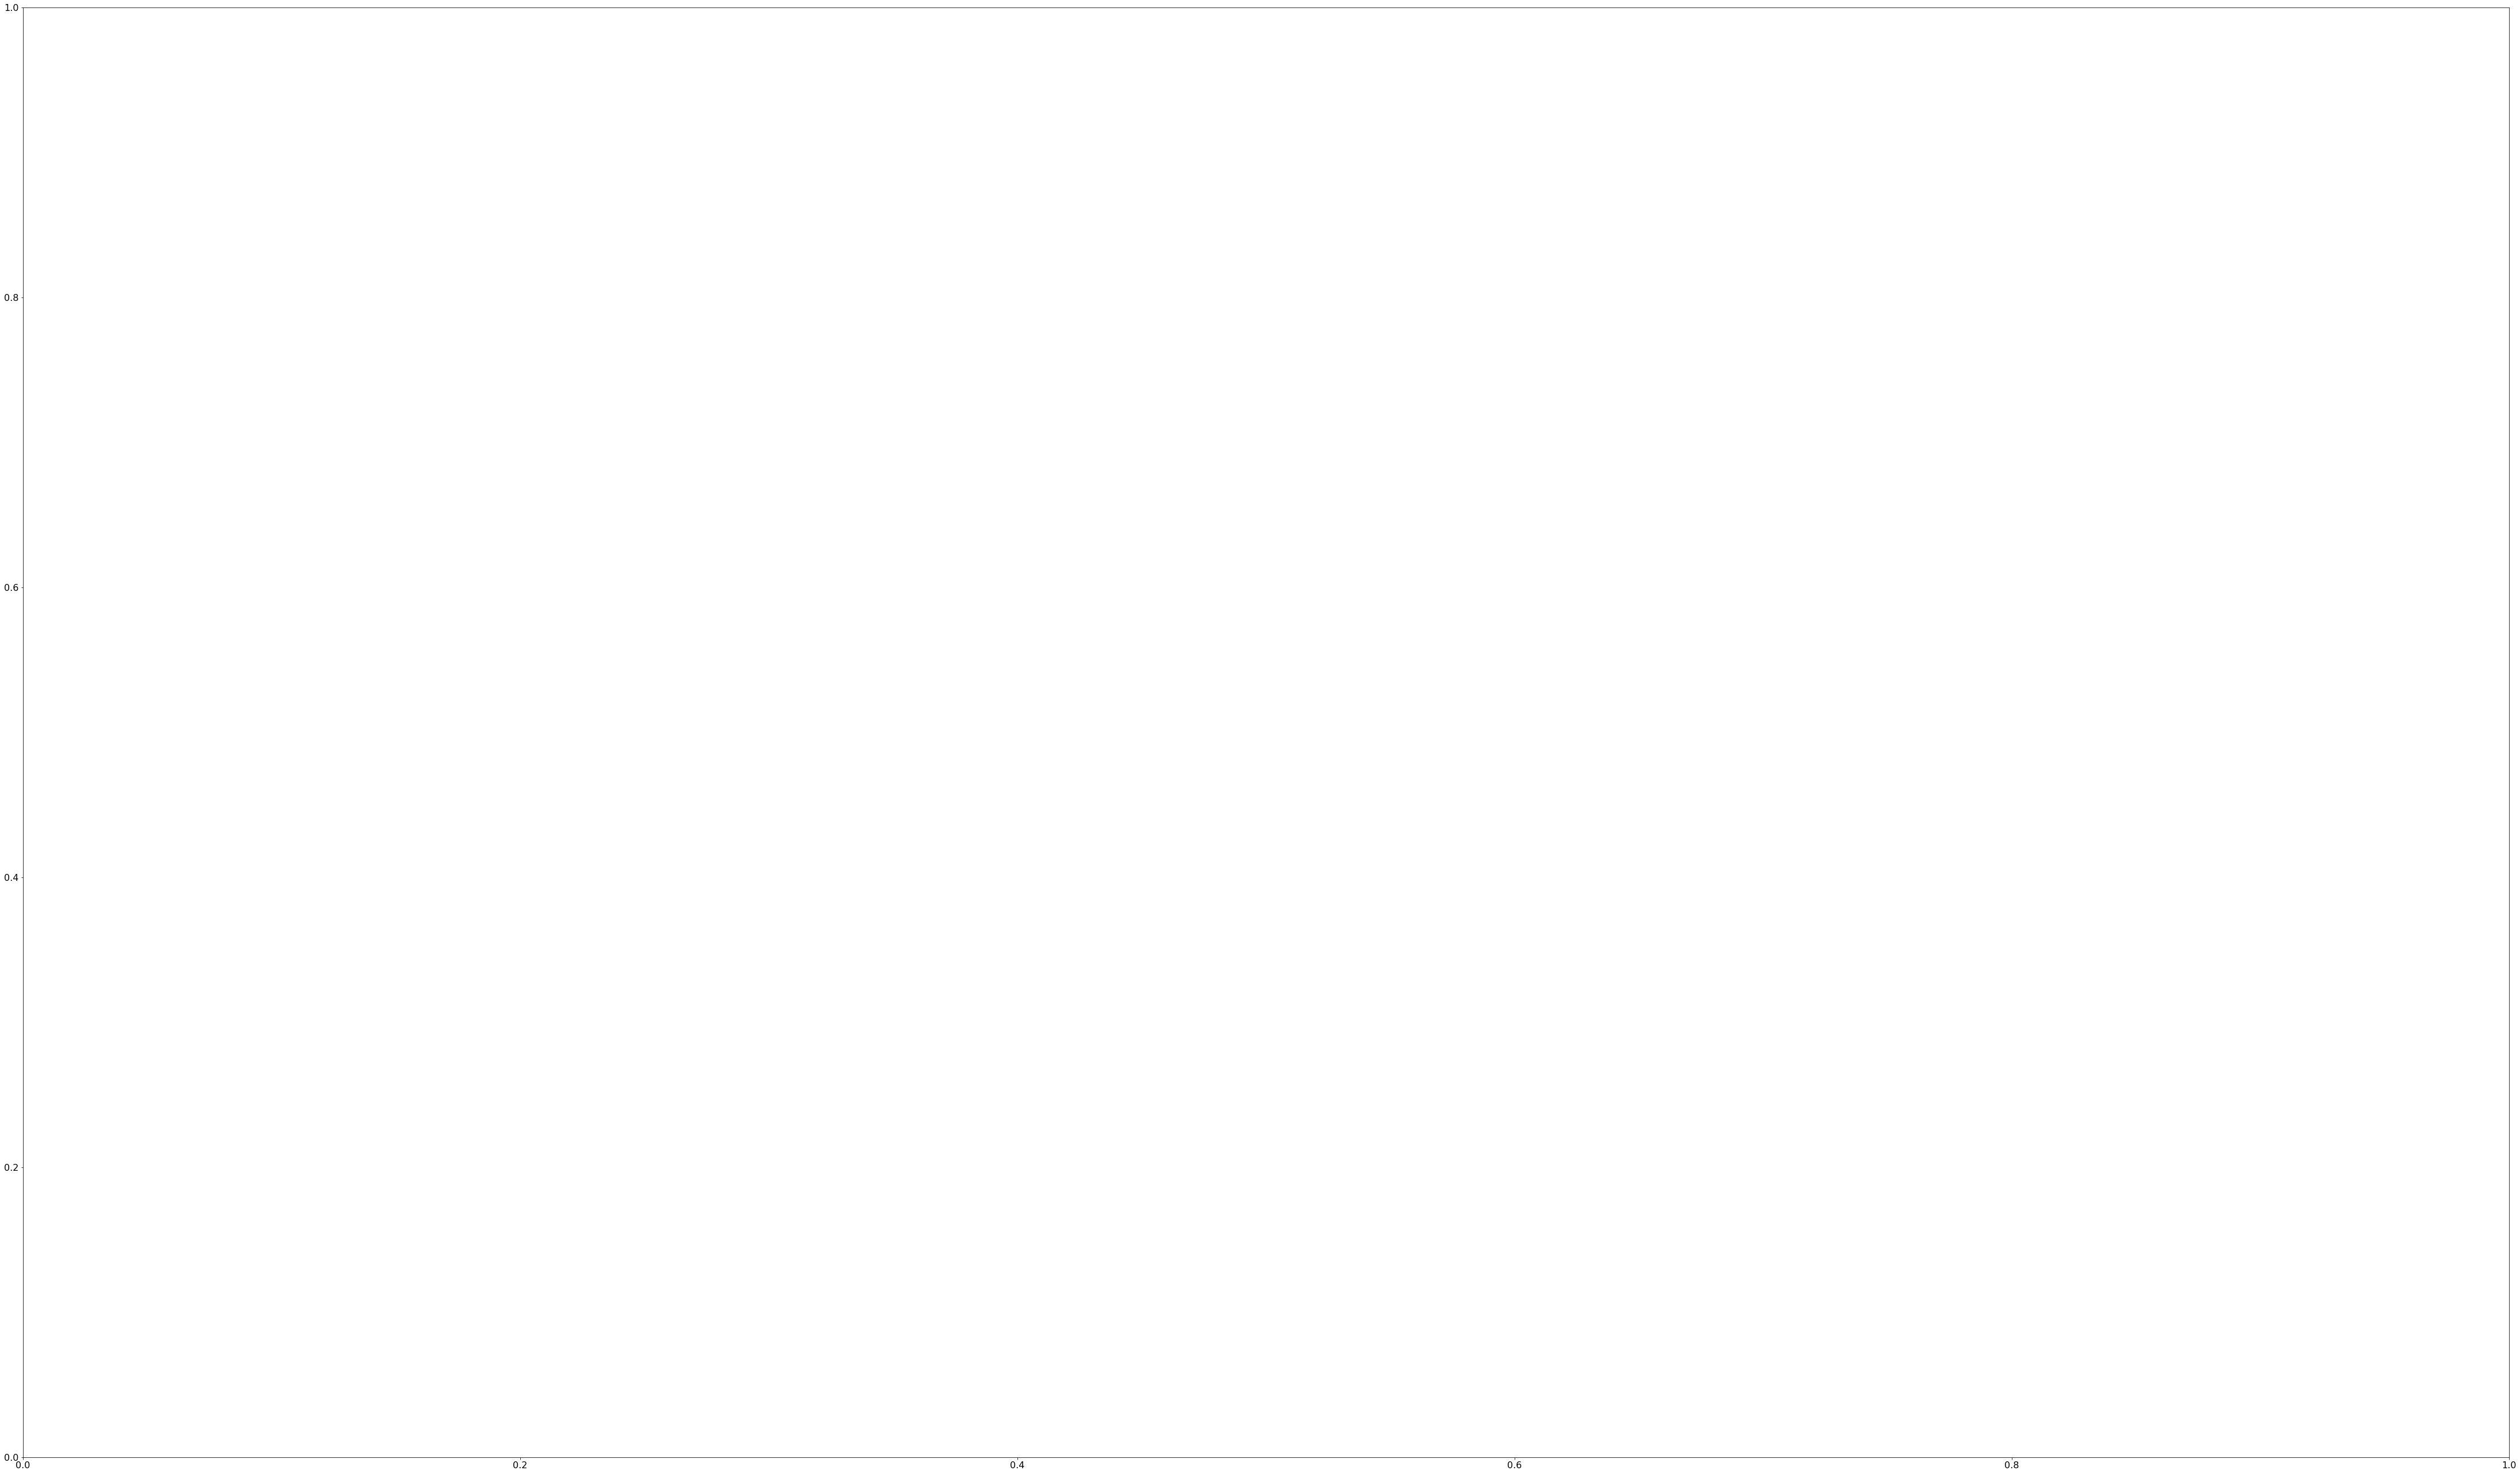

In [60]:
df_two_features = [df_all['Age'].values, df_all['Fare'].values]

fig = plt.figure(figsize=(12,7))
axes = fig.add_axes([0,0,5,5])


#axes = fig.add_subplot([0,1]) 
#ax = fig.add_axes([0,0,10,10],label='test')

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))


# plot violin plot
axes[0].violinplot(df_two_features
                   ,showmeans=False,
                    showmedians=True)
axes[0].set_title('Age and ... Distribution')


### # plot box plot
### axes[1].boxplot(all_data)
### axes[1].set_title('Box plot')

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(df_two_features))])
    ax.set_xlabel('Four separate samples')
    ax.set_ylabel('Observed values')

# add x-tick labels
plt.setp(axes, xticks=[y + 1 for y in range(len(df_two_features))],
         xticklabels=['x1', 'x2'])
plt.show()

In [ ]:
df_all[['Pclass','Age']]

### Gaussian distrbution for age and fare price zu survived = 1

https://matplotlib.org/gallery/statistics/histogram_multihist.html#sphx-glr-gallery-statistics-histogram-multihist-py

Am Ende müssen sich alle Eingerenzungen durch die Visualisierungen in den Prediction Model wiederfinden.
(z.B.: min age, max age, mean age, in der Klasse xyz sorgt dafpr, dass du eher überlebts ...)

In [ ]:
# Pivot for age and fare
table = pd.DataFrame.pivot_table(df_all_survived, values=['Fare', 'Age', 'Survived'], index=['Sex', 'Pclass'],
                     aggfunc={'Fare': np.mean,'Age': [min, max, np.mean], 'Survived': ['sum']})
table

In [ ]:
df_all_survived.groupby(['Age','Survived']).agg('count')

# Schrottsammler


In [ ]:
n_groups = 10

# Mans value count per type
means_men = df_all.groupby(['Sex']).count().loc['male',:].values
#std_men = (2, 3, 4, 1, 2)

# Womens value count per type
means_women = df_all.groupby(['Sex']).count().loc['female',:].values
#std_women = (3, 5, 2, 3, 3)



fig, ax = plt.subplots(figsize=(10,6))


index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_men, bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
                label='Men')

rects2 = ax.bar(index + bar_width, means_women, bar_width,
                alpha=opacity, color='g',
                error_kw=error_config,
                label='Women')

ax.set_xlabel('Group')
ax.set_ylabel('Count')
ax.set_title('Scores by group and gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Pclass','Name','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Family'))
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
df_all.groupby(['Sex','Pclass']).count().index
df_all.groupby(['Sex','Pclass']).count()['female']
#index.levels[1]
#df_all.groupby(['Sex','Pclass']).count().index.levels[0]

In [ ]:
#df_all.groupby(['Sex']).count().Name
#df_all.groupby(['Sex','Pclass']).count().Name

df_all.groupby(['Sex','Pclass']).count().loc['female']

#df_all.groupby(['Sex','Pclass']).count().loc

#.loc['male']



In [ ]:
#df_all.pivot(columns='Sex', values=['Fare','Pclass'])
df_all.pivot(columns='Pclass', values=['Fare']) # very good one


In [ ]:
#df_all['Sex'].values
#Survived.values
df_all.groupby(['Sex']).count().Name.male

In [ ]:

#fig = plt.figure() # figure
#fig.suptitle('Gender Seperation on 'Titanic')

fig, ax = plt.subplots(1,1)
#my_plotter(ax,df_train['Sex'].values, Survived.values, {: 'x'})
my_bar(ax, df_train['Sex'].values, Survived.values, {'facecolor':'r'})


In [ ]:
#df_all[['Sex','Age','SibSp','Parch','Embarked','Family']].hist(Survived)
pd.concat([df_train, Survived], axis=1).hist()
#.hist()


In [ ]:
df_all.groupby(['Sex']).count().loc['female',:].values

In [ ]:
df_all.pivot("Pclass", "Age", "Sex")

#passengers = sns.load_dataset("flights")
#flights = df_all.pivot("Pclass", "Age", "Sex")
#ax = sns.heatmap(flights)